### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from dataset import BaseSegmentationDataset, build_mapping_array, COLORS, DEFAULT_UK_CLASS
from model_uos import DeepLabUOS
from conformal_prediction import calibrate_conformal, conformal_mask
from train_eval import evaluate_metrics, calculate_mIoU
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import seaborn as sns

### Globals

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

CITYSCAPES_ROOT = "datasets/realcityscapes"
LOSTANDFOUND_ROOT = "datasets/lostandfound"

mapping_array = build_mapping_array(unknown_obstacle_id=DEFAULT_UK_CLASS)

n_classes = 7

# Training parameters
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4

# Model and training setup
MODEL_PATH = "deeplab_uos_trained.pth"
EPOCHS = 0
start_epoch = 0
best_mIoU = 0.0

alpha = 0.1  # Confidence threshold for conformal calibration

Device: cuda


### Utils

In [3]:
def uos_plot(obj_map_masked, us_map_masked, uos_map_masked):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(obj_map_masked, cmap="viridis")
    plt.title("Objectness (masked, full image)")
    plt.colorbar(); plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(us_map_masked, cmap="magma")
    plt.title("US (masked, full image)")
    plt.colorbar(); plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(uos_map_masked, cmap="plasma")
    plt.title("UOS (masked, full image)")
    plt.colorbar(); plt.axis("off")

    plt.suptitle("Objectness vs US vs UOS (full image, masked=0)", fontsize=14)
    plt.show()

In [4]:
def plot_roc_pr(all_scores, all_gts, title_suffix="(OoD Obstacles)"):
    mask = (all_gts == 0) | (all_gts == 1)
    y_true = all_gts[mask]
    y_score = all_scores[mask]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    RocCurveDisplay.from_predictions(y_true, y_score, ax=axes[0])
    axes[0].set_title(f"ROC Curve {title_suffix}")

    # PR Curve
    PrecisionRecallDisplay.from_predictions(y_true, y_score, ax=axes[1])
    axes[1].set_title(f"Precision-Recall Curve {title_suffix}")

    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [5]:
def test_plotting(all_scores, all_gts):
    # Plotting distribution of UOS scores
    ood_scores = all_scores[all_gts == 1]
    ind_scores = all_scores[all_gts == 0]
    plt.figure(figsize=(8,4))
    sns.kdeplot(ind_scores, label="In-Distribution", fill=True, alpha=0.5)
    sns.kdeplot(ood_scores, label="OoD", fill=True, alpha=0.5)
    plt.title("Distribution of UOS Scores (OoD vs In-Distribution)")
    plt.xlabel("UOS score")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    # Plot ROC + PR curves
    plot_roc_pr(all_scores, all_gts)



In [6]:
def mask_road_and_obstacles(gt_mask, road_id=1, obstacle_id=4):
    """
    Only keeps road and obstacle pixels, masking all the rest with -1 (ignored).
    Returns a mask where:
    - Road pixels are set to 0 (negative class)
    - Obstacle pixels are set to 1 (positive class)
    - All other pixels are set to -1 (ignored)
    """
    # Create an evaluation mask initialized to -1
    eval_mask = np.full_like(gt_mask, -1, dtype=np.int8)
    # Road pixels are set to 0
    eval_mask[gt_mask == road_id] = 0
    # Obstacle pixels are set to 1
    eval_mask[gt_mask == obstacle_id] = 1

    return eval_mask

In [7]:
def filter_exclude_giant(gt_mask, max_exclude=80000):
    """
    Filters out connected components in the ground truth mask that are larger than a specified size.
    """
    filtered = np.copy(gt_mask)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(gt_mask, connectivity=8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > max_exclude:
            filtered[labels == i] = 0
    return filtered

In [8]:
def decode_segmap(mask):
    """Converts a mask [H,W] of classes in an RGB colored image."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id, color in enumerate(COLORS):
        color_mask[mask == cls_id] = color
    return color_mask

In [9]:
# Plotting function
def plot_prediction_full(img, pred_classes, pred_mask_ood,
                         title_classes="Model Prediction", title_ood="Prediction with OoD Highlight"):
    """
    Display 3 side-by-side images:
    1) Original input image
    2) Predicted classes (colored)
    3) Predicted classes with OoD highlighted (white overlay)

    Args:
        img: torch.Tensor [C,H,W] - input image
        pred_classes: np.array [H,W] - predicted class indices (0..n_classes-1)
        pred_mask_ood: np.array [H,W] - binary mask (1 = OoD, 0 = In-distribution)
    """
    # ✅ Prepare input image (normalize to [0,1])
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # ✅ Decode class predictions into RGB colors
    pred_color = decode_segmap(pred_classes)

    # ✅ Create an overlay: white color for OoD pixels
    overlay = pred_color.copy()
    overlay[pred_mask_ood == 1] = (255, 255, 255)

    # ✅ Plot all three side by side
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_color)
    plt.title(title_classes)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(title_ood)
    plt.axis("off")

    plt.show()


In [10]:
def plot_full_paper_style(img, gt_multi, gt_ood_filtered, pred_ood, title="OoD Detection"):
    img_np = (img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    gt_color = decode_segmap(gt_multi)
    overlay = np.copy(img_np)
    
    tp = (gt_ood_filtered == 1) & (pred_ood == 1)
    fp = (gt_ood_filtered == 0) & (pred_ood == 1)
    fn = (gt_ood_filtered == 1) & (pred_ood == 0)
    overlay[tp] = [0, 255, 0] # True Positives (Green)
    overlay[fp] = [255, 0, 0] # False Positives (Red)
    overlay[fn] = [0, 0, 255] # False Negatives (Blue)
    blended = cv2.addWeighted(img_np, 0.5, overlay, 0.5, 0) # Blend the original image with the overlay

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 2); plt.imshow(gt_color); plt.title("GT Multi-class"); plt.axis("off")
    plt.subplot(1, 4, 3); plt.imshow(gt_ood_filtered, cmap="gray"); plt.title("GT OoD (Filtered)"); plt.axis("off")
    plt.subplot(1, 4, 4); plt.imshow(blended); plt.title("TP(G)/FP(R)/FN(B)"); plt.axis("off")
    plt.show()

### Data

In [11]:
transform = torch.nn.Sequential()

train_dataset = BaseSegmentationDataset(
    img_dir=os.path.join(CITYSCAPES_ROOT, 'leftImg8bit/train'),
    label_dir=os.path.join(CITYSCAPES_ROOT, 'gtFine/train'),
    mapping_array=mapping_array,
    transform=None,
    ood_mode=False
)

val_dataset = BaseSegmentationDataset(
    img_dir=os.path.join(CITYSCAPES_ROOT, 'leftImg8bit/val'),
    label_dir=os.path.join(CITYSCAPES_ROOT, 'gtFine/val'),
    mapping_array=mapping_array,
    transform=None,
    ood_mode=False
)

test_dataset = BaseSegmentationDataset(
    img_dir=os.path.join(LOSTANDFOUND_ROOT, 'leftImg8bit/test'),
    label_dir=os.path.join(LOSTANDFOUND_ROOT, 'gtCoarse/test'),
    mapping_array=mapping_array,
    transform=None,
    ood_mode=True
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Model

In [12]:
model = DeepLabUOS(n_classes=n_classes, normalize_uos=True).to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=255)

if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    if "optimizer_state" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint.get("epoch", -1) + 1
    best_mIoU = checkpoint.get("mIoU", 0.0)
    print(f"Restarting from Epoch {start_epoch} (Best mIoU {best_mIoU:.4f})")
else:
    print("No model found, training from zero.")

Restarting from Epoch 69 (Best mIoU 0.7754)


C:\Users\colam\AppData\Local\Temp\ipykernel_22680\3920868114.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


### Training

In [13]:
max_iter = (EPOCHS + start_epoch) * len(train_loader)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda it: (1 - it / max_iter) ** 0.9)

train_losses, val_mious = [], []

for epoch in range(start_epoch, EPOCHS + start_epoch):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS+start_epoch}", leave=False)

    for imgs, labels in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        logits = out["logits"]
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{epoch_loss / (progress_bar.n + 1):.4f}"})

    avg_loss = epoch_loss / len(train_loader)
    val_mIoU = calculate_mIoU(model, val_loader)
    train_losses.append(avg_loss)
    val_mious.append(val_mIoU)
    print(f"Epoch {epoch+1}/{EPOCHS+start_epoch} - Train Loss: {avg_loss:.4f} | Val mIoU: {val_mIoU:.4f}")

    if val_mIoU > best_mIoU:
        best_mIoU = val_mIoU
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "mIoU": best_mIoU
        }, MODEL_PATH)
        print(f"Best model updated (Val mIoU: {best_mIoU:.4f})")

print(f"Training completed! Best final Val mIoU: {best_mIoU:.4f}")

Training completed! Best final Val mIoU: 0.7754


### Testing

In [14]:
# Conformal Calibration
calib_scores = []
model.eval()
with torch.no_grad():
    for imgs, _ in val_loader:
        uos = model(imgs.to(device))["uos"]
        calib_scores.append(uos.cpu().numpy())

calib_scores = np.concatenate(calib_scores).flatten()
qhat = calibrate_conformal(calib_scores, alpha=alpha)
print(f"Conformal threshold q_hat: {qhat}")

Conformal threshold q_hat: 0.380832701921463


In [15]:
all_scores, all_gts = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        out = model(imgs.to(device))
        uos = out["uos"].cpu().numpy()

        for i in range(uos.shape[0]):
            uos[i, 0] = cv2.GaussianBlur(uos[i, 0], (5, 5), 0)

            gt_eval = mask_road_and_obstacles(labels[i].numpy(), road_id=1, obstacle_id=4)
            valid_pixels = gt_eval != -1  # ✅ Only road + obstacles

            uos_map = uos[i, 0]
            all_scores.append(uos_map[valid_pixels])
            all_gts.append(gt_eval[valid_pixels])  # ✅ No -1 values now

# ✅ Concatenate valid pixels only
all_scores = np.concatenate(all_scores).astype(float).flatten()
all_gts = np.concatenate(all_gts).astype(int).flatten()

# ✅ Check
assert set(np.unique(all_gts)).issubset({0, 1}), f"Invalid values in GT: {np.unique(all_gts)}"

print("OoD pixel count:", np.sum(all_gts))
print("Scores range:", all_scores.min(), all_scores.max())

metrics = evaluate_metrics(all_scores, all_gts)
print(f"AUROC: {metrics['AUROC']:.4f} | AP: {metrics['AP']:.4f} | FPR95: {metrics['FPR95']:.4f}")

Testing: 100%|██████████| 1203/1203 [02:05<00:00,  9.59it/s]


OoD pixel count: 184899
Scores range: 2.824120798328167e-11 0.9974439740180969
AUROC: 0.9681 | AP: 0.4909 | FPR95: 0.1612


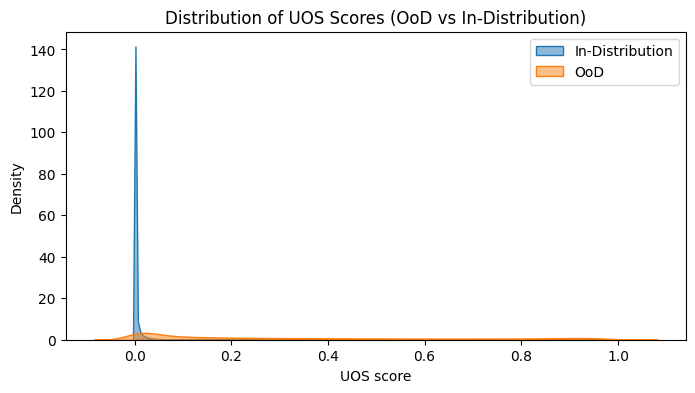

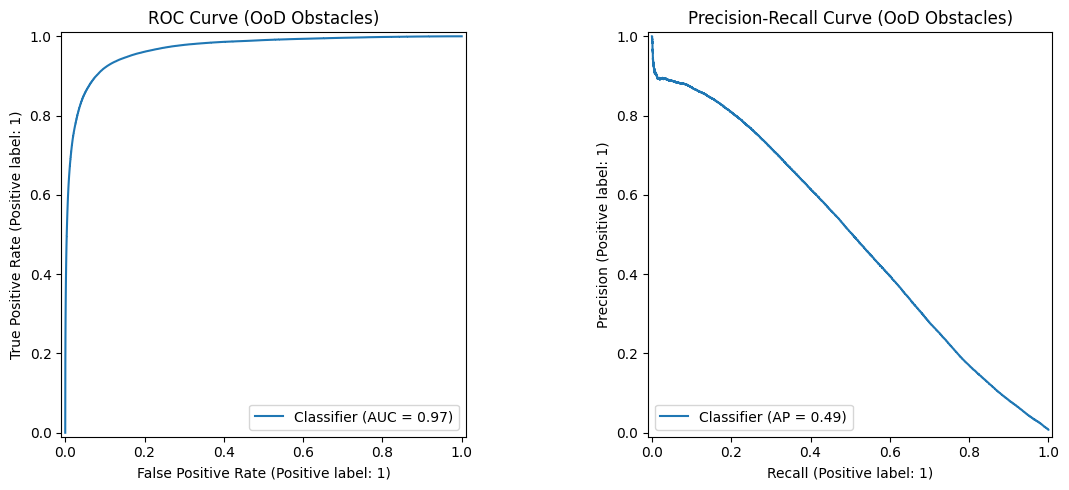

In [16]:
test_plotting(all_scores, all_gts)

### Plots

Sample:  36


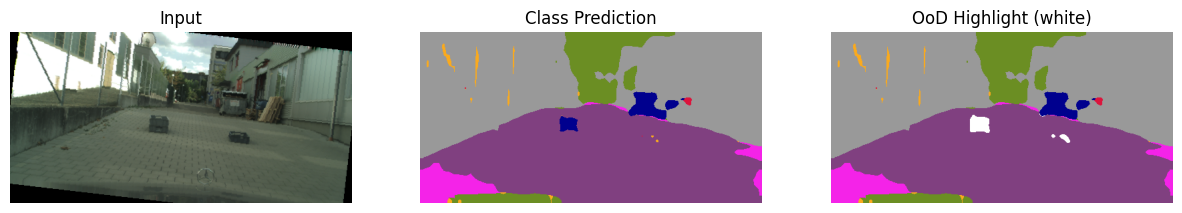

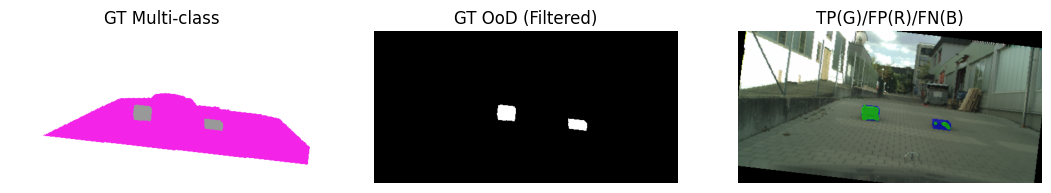

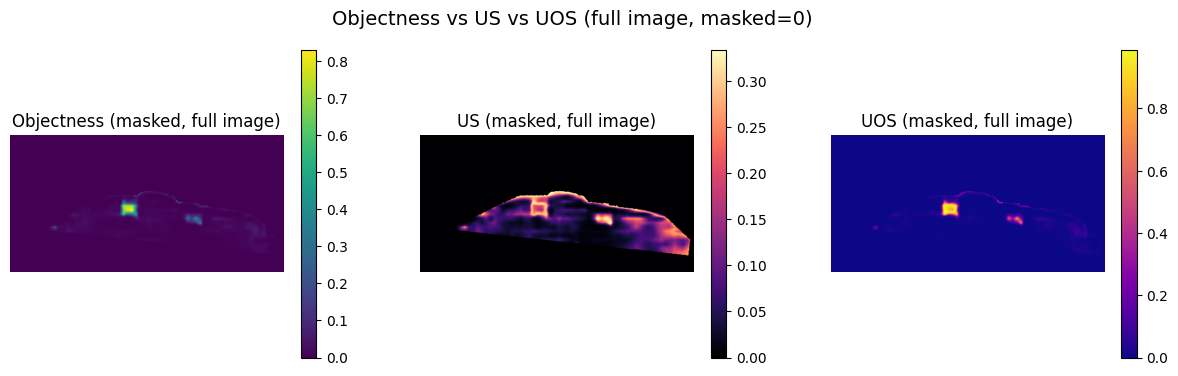

In [17]:
sample_idx = 36
print(f"Sample: ",sample_idx)
with torch.no_grad():
    for idx, (imgs, labels) in enumerate(test_loader):
        if idx < sample_idx:
            continue

        imgs = imgs.to(device)
        out = model(imgs)

        objectness = out["objectness"].cpu().numpy()
        us = out["us"].cpu().numpy()
        uos = out["uos"].cpu().numpy()

        obj_map = objectness[0, 0]
        us_map = us[0, 0]
        uos_map = uos[0, 0]
        uos_map = cv2.GaussianBlur(uos_map, (5, 5), 0)

        # Conformal threshold
        pred_mask = conformal_mask(uos_map,qhat).astype(np.uint8)

        # GT mask: road + obstacles only (LostAndFound protocol)
        lbl_np = labels.squeeze(0).numpy()
        gt_eval = mask_road_and_obstacles(lbl_np, road_id=1, obstacle_id=4)
        valid_pixels = gt_eval != -1

        # OoD mask on valid pixels only
        gt_mask_ood = (gt_eval == 1).astype(np.uint8)

        # Plot class predictions 
        pred_mask_c = out["logits"].argmax(dim=1).squeeze(0).cpu().numpy()
        plot_prediction_full(
            imgs[0], 
            pred_mask_c,        # class predictions (argmax from logits)
            pred_mask * valid_pixels,          # OoD binary mask
            title_classes="Class Prediction", 
            title_ood="OoD Highlight (white)"
        )

        plot_full_paper_style(imgs[0], lbl_np, gt_mask_ood, pred_mask * valid_pixels,
                              title=f"Sample {idx}")
        
                # Original maps' copies for masking
        obj_map_masked = obj_map.copy()
        us_map_masked = us_map.copy()
        uos_map_masked = uos_map.copy()

        # Set to 0 the pixels outside valid_pixels (instead of np.nan)
        obj_map_masked[~valid_pixels] = 0.0
        us_map_masked[~valid_pixels] = 0.0
        uos_map_masked[~valid_pixels] = 0.0

        # Plot
        uos_plot(obj_map_masked, us_map_masked, uos_map_masked)
        break